# Covid 19 Feature Engineering and Modeling

## Contents:

* Imports
* Load dataset
* Data Preparetion
    * Decomposition positive cases
    * Decomposition death cases
* Stationarity check
    * Making stationarity
* Hyperparameter Tuning
* Fit the models
* Statistics of the models
* Forecasting the models
* Visualization of the forecasting
* Saved the models and forecasting

## Imports

In [22]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV
from sklearn.metrics import confusion_matrix

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

from statsmodels.tsa.seasonal import seasonal_decompose

from statsmodels.tsa.stattools import adfuller

import matplotlib.dates as mdates

import pytz
import pickle



## Load dataset

In [3]:
df = pd.read_csv('../Data/cleaned_data.csv')
df.set_index('date',inplace=True)
df

,confirmed,death
date,,
2020-01-22,1,1
2020-01-23,1,1
2020-01-24,2,1
2020-01-25,2,1
2020-01-26,5,1
...,...,...
2023-03-05,103646975,1122134
2023-03-06,103655539,1122181
2023-03-07,103690910,1122516


## Data Preparation

#### Decomposition positive case

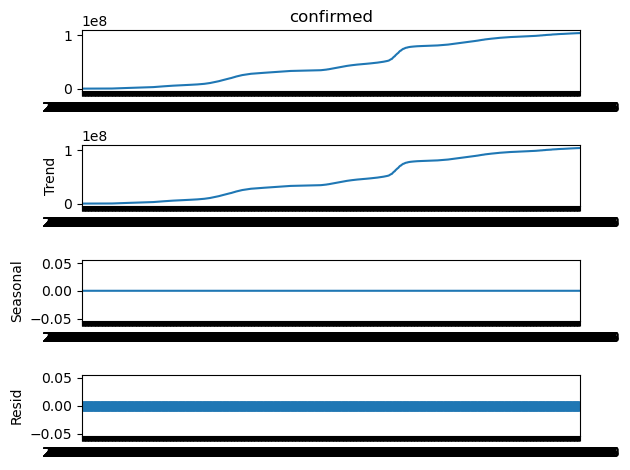

In [3]:
# Set the color palette
crest_palette = sns.color_palette('crest')
# Decompose the 'confirmed' series
confirmed_decomposition = seasonal_decompose(df['confirmed'], model='additive',period=1)

# Plot the decomposed components
confirmed_decomposition.plot()
plt.show()

#### Decomposition death cases

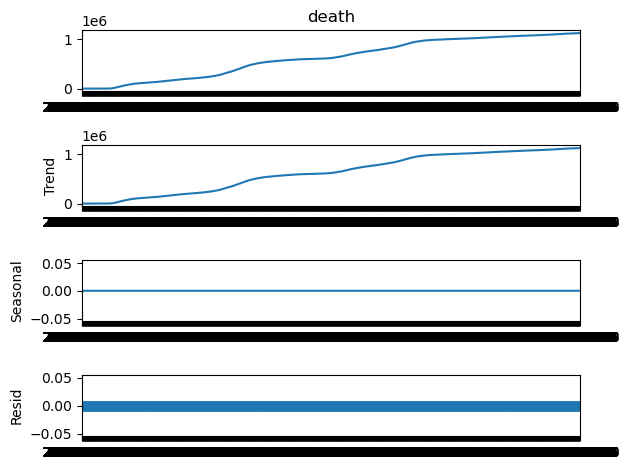

In [4]:
# Decompose the 'death' series
death_decomposition = seasonal_decompose(df['death'], model='additive',period=1)

# Plot the decomposed components
death_decomposition.plot()
plt.show()

## Stationarity check

In [4]:
from statsmodels.tsa.stattools import kpss
y_confirmed = df['confirmed']
kpss(y_confirmed)


/Users/martin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(5.482928669670309,
 0.01,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

In [5]:
y_death = df['death']
kpss(y_death)

/Users/martin/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/stattools.py:2018: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  warnings.warn(


(5.498790275122215,
 0.01,
 20,
 {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})

Additionally, the p-value (0.01) is less than the significance level of 1%. This also suggests rejecting the null hypothesis.
In both cases, the results suggest that the null hypothesis of stationarity is rejected, indicating that the time series data for both "confirmed" and "death" is likely non-stationary.

In [6]:
def test_stationarity(timeseries):
    #Dickey-Fuller test
    result = adfuller(timeseries, autolag='AIC')
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:', result[4])

test_stationarity(df['confirmed'])
test_stationarity(df['death'])

ADF Statistic: -0.03337976177109115
p-value: 0.9556829980610061
Critical Values: {'1%': -3.436207340777824, '5%': -2.8641263411190323, '10%': -2.5681470422493593}
ADF Statistic: -1.7647214589397018
p-value: 0.3981117527772616
Critical Values: {'1%': -3.4362020989495545, '5%': -2.864124028818559, '10%': -2.5681458107461737}


In both cases, the p-values are greater than the typical significance levels (e.g., 0.05), indicating that I fail to reject the null hypothesis. Therefore, you do not have enough evidence to conclude that the time series are stationary.

To summarize, based on the ADF test results, the datasets for both confirmed and death appear to be non-stationary.

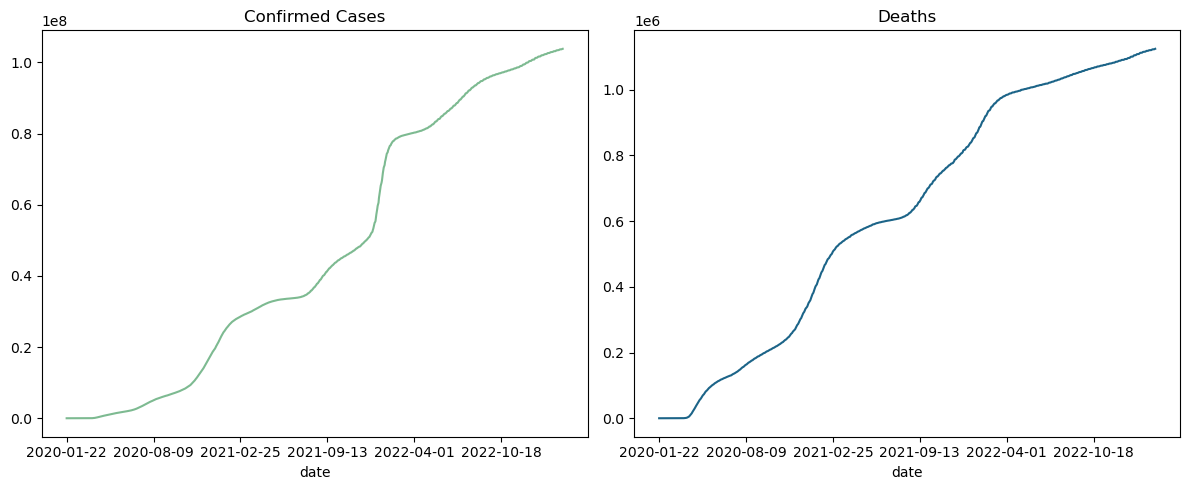

In [6]:
# Set the color palette
crest_palette = sns.color_palette('crest')

# Create subplots
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12, 5))

# Plot 'confirmed' column with 'crest' color palette in the first subplot
df['confirmed'].plot(ax=axes[0], color=crest_palette[0])
axes[0].set_title('Confirmed Cases')

# Plot 'death' column in the second subplot
df['death'].plot(ax=axes[1], color=crest_palette[4])
axes[1].set_title('Deaths')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


#### Making stationarity

In [7]:
df['confirmed']  = np.log(df['confirmed'])
df['death']  = np.log(df['death'])

test_stationarity(df['confirmed'])
test_stationarity(df['death'])

ADF Statistic: -9.095787396441516
p-value: 3.7183306101979044e-15
Critical Values: {'1%': -3.436207340777824, '5%': -2.8641263411190323, '10%': -2.5681470422493593}
ADF Statistic: -6.48504249689365
p-value: 1.2670556457493723e-08
Critical Values: {'1%': -3.4361604996756685, '5%': -2.864105678204421, '10%': -2.568136037454102}


Given that the p-values are well below typical significance levels (e.g., 0.05), you can reject the null hypothesis. Therefore, based on the ADF test results, the datasets in both cases appear to be stationary.

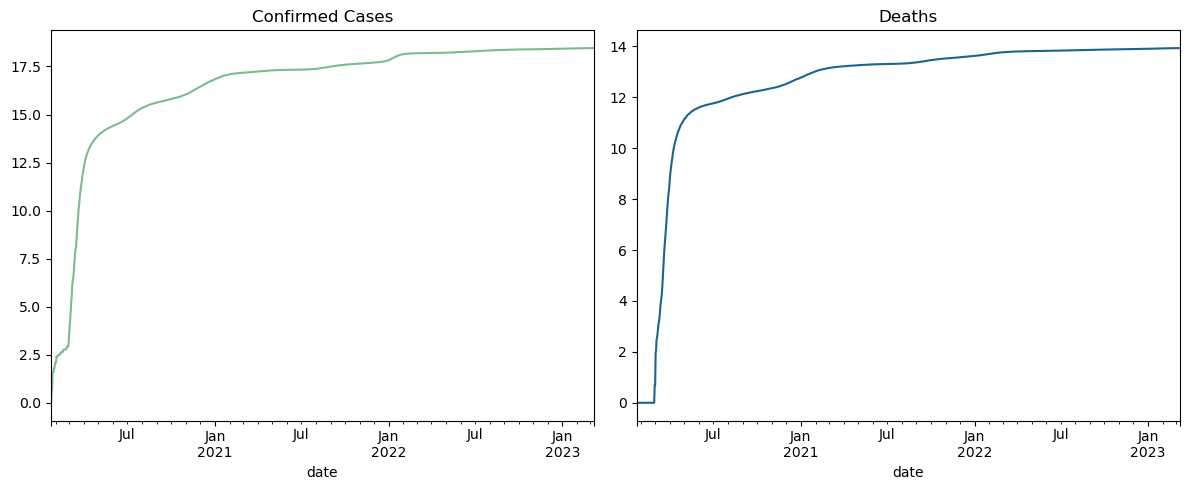

In [55]:
# Set the color palette
crest_palette = sns.color_palette('crest')

# Create subplots
fig, axes = plt.subplots(nrows=1,ncols=2, figsize=(12, 5))

# Plot 'confirmed' column with 'crest' color palette in the first subplot
df['confirmed'].plot(ax=axes[0], color=crest_palette[0])
axes[0].set_title('Confirmed Cases')

# Plot 'death' column in the second subplot
df['death'].plot(ax=axes[1], color=crest_palette[4])
axes[1].set_title('Deaths')

# Adjust layout for better spacing
plt.tight_layout()

# Show the plots
plt.show()


## Hyperparameter Tuning

In [9]:
# Make a function called evaluate_arima_model to find the MSE of a single ARIMA model
def evaluate_arima_model(data, arima_order):
    try:
        
        # Needs to be an integer because it is later used as an index.
        #split = int(len(data) * 0.8)
        # Make train and test variables
        #train, test = data[0:split], data[split:]
        
        # Define the end date for the training set
        train_end_date = '2022-01-23' # dates cover 2020-01-22 to 2023-03-09
        # Split the dataset
        train = data[:train_end_date]
        test = data[train_end_date:]
        past = [x for x in train]
        # Make predictions
        predictions = list()
        for i in range(len(test)):
            model = ARIMA(past, order=arima_order)
            model_fit = model.fit()
            future = model_fit.forecast()[0]
            predictions.append(future)
            past.append(test[i])
        # Calculate out-of-sample error
        error = mean_squared_error(test, predictions)
        # Return the error
        return error
    except Exception as e:
        print(f"Error in evaluate_arima_model: {e}")
        return np.inf  # Return infinity for cases where the model did not converge or encountered an issue

# Make a function called evaluate_models to evaluate different ARIMA models with several different p, d, and q values.
def evaluate_models(dataset, column, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    # Iterate through p_values
    for p in p_values:
        # Iterate through d_values
        for d in d_values:
            # Iterate through q_values
            for q in q_values:
                # p, d, q iterator variables in that order
                order = (p, d, q)
                # Make a variable called mse for the Mean squared error
                mse = evaluate_arima_model(dataset[column], order)
                if mse < best_score:
                    best_score, best_cfg = mse, order
                print(f'ARIMA {order} MSE={mse:.3f} for {column}')
    return print(f'Best ARIMA {best_cfg} MSE= {best_score:.3f} for {column}')

# Now, we choose a couple of values to try for each parameter: p_values, d_values, and q_values
# Fill in the blanks as appropriate
p_values = [x for x in range(0, 3)]
d_values = [x for x in range(0, 3)]
q_values = [x for x in range(0, 3)]

# Finally, we can find the optimum ARIMA model for our data.
# This can take a while...!
import warnings
warnings.filterwarnings("ignore")

# Evaluate for 'positive'
evaluate_models(df, 'confirmed', p_values, d_values, q_values)

# Evaluate for 'death'
evaluate_models(df, 'death', p_values, d_values, q_values)

ARIMA (0, 0, 0) MSE=5.426 for confirmed
ARIMA (0, 0, 1) MSE=1.366 for confirmed
ARIMA (0, 0, 2) MSE=0.353 for confirmed
ARIMA (0, 1, 0) MSE=0.000 for confirmed
ARIMA (0, 1, 1) MSE=0.000 for confirmed
ARIMA (0, 1, 2) MSE=0.000 for confirmed
ARIMA (0, 2, 0) MSE=0.000 for confirmed
ARIMA (0, 2, 1) MSE=0.000 for confirmed
ARIMA (0, 2, 2) MSE=0.000 for confirmed
ARIMA (1, 0, 0) MSE=0.000 for confirmed
ARIMA (1, 0, 1) MSE=0.000 for confirmed
ARIMA (1, 0, 2) MSE=0.000 for confirmed
ARIMA (1, 1, 0) MSE=0.000 for confirmed
ARIMA (1, 1, 1) MSE=0.000 for confirmed
Error in evaluate_arima_model: Schur decomposition solver error.
ARIMA (1, 1, 2) MSE=inf for confirmed
ARIMA (1, 2, 0) MSE=0.000 for confirmed
ARIMA (1, 2, 1) MSE=0.000 for confirmed
ARIMA (1, 2, 2) MSE=0.000 for confirmed
Error in evaluate_arima_model: LU decomposition error.
ARIMA (2, 0, 0) MSE=inf for confirmed
ARIMA (2, 0, 1) MSE=0.000 for confirmed
ARIMA (2, 0, 2) MSE=0.000 for confirmed
ARIMA (2, 1, 0) MSE=0.000 for confirmed
ARIM

## Fit the models

In [33]:
p=1
d=1
q=1
# Define the end date for the training set
train_end_date = '2022-11-01' # dates cover 2020-01-22 to 2023-03-09
# Split the dataset
train = df['confirmed'][:train_end_date]
test = df['confirmed'][train_end_date:]
past = [x for x in train]
# Fit the ARIMA model for 'confirmed' series
confirmed_model = ARIMA(past, order=(p,d,q))
confirmed_results = confirmed_model.fit()


p=1
d=1
q=1
train = df['death'][:train_end_date]
test = df['death'][train_end_date:]
past = [x for x in train]
# Fit the ARIMA model for 'death' series
death_model = ARIMA(past, order=(p,d,q))
death_results = death_model.fit()


## Statistics of the models

In [36]:
print('confirmed summary:', confirmed_results.summary())
print('\n' + '-'*100 + '\n') 
print('death summary:', death_results.summary())

confirmed summary:                                SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 1016
Model:                 ARIMA(1, 1, 1)   Log Likelihood                1740.549
Date:                Sat, 20 Jan 2024   AIC                          -3475.098
Time:                        14:57:00   BIC                          -3460.330
Sample:                             0   HQIC                         -3469.489
                               - 1016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9860      0.001    716.070      0.000       0.983       0.989
ma.L1         -0.7311      0.007   -104.861      0.000      -0.745      -0.717
sigma2         0.0019   1.61e-05 

* Confirmed Cases Model (ARIMA(1, 1, 1)):
    * Model Parameters:
         ARIMA(1, 1, 1) indicates a first-order autoregressive process with differencing and a first-order moving average component.
        The coefficients for the autoregressive (AR) and moving average (MA) terms are 0.9859 and -0.7313, respectively.
    * Goodness of Fit:
        Log Likelihood: 1137.458
        AIC (Akaike Information Criterion): -2268.917
        BIC (Bayesian Information Criterion): -2255.125
        HQIC (Hannan-Quinn Information Criterion): -2263.597
        **The lower AIC, BIC, and HQIC values suggest a better fit of the model to the data.**
    * Residuals Analysis:
        Ljung-Box (Q) statistic: 27.63, with a p-value of 0.00, **indicating no significant autocorrelation in residuals.**
        Jarque-Bera (JB) statistic: 206386.01, with a p-value of 0.00, **suggesting departure from normality.**
        Heteroskedasticity:
            * Heteroskedasticity test indicates a p-value of 0.00, **suggesting the presence of heteroskedasticity in residuals.**
* Death Cases Model (ARIMA(1, 1, 1)):
    * Model Parameters:
       ARIMA(1, 1, 1) structure with AR and MA coefficients of 0.9742 and -0.7576, respectively.
    * Goodness of Fit:
        Log Likelihood: 1109.337
        AIC: -2212.674
        BIC: -2198.882
        HQIC: -2207.354
        Similar to confirmed cases, lower AIC, BIC, and HQIC values suggest a good fit.
    * Residuals Analysis:
        Ljung-Box (Q) statistic: 39.33, with a p-value of 0.00, indicating no significant autocorrelation in residuals.
        Jarque-Bera (JB) statistic: 3203169.74, with a p-value of 0.00, suggesting departure from normality.
        Heteroskedasticity:
            *Heteroskedasticity test indicates a p-value of 0.00, indicating the presence of heteroskedasticity in residuals.
* Conclusion:
**Both models seem to fit the data well based on the AIC, BIC, and HQIC values.
Residuals in both models show no significant autocorrelation but exhibit departure from normality.
Heteroskedasticity is present in both models, indicating variability in residuals.**


## Forcasting the models

In [34]:
# Define the number of periods to forecast
forecast_periods = len(df['confirmed']['2022-11-01':])

# Forecast 'confirmed'
confirmed_forecast = confirmed_results.get_forecast(steps=forecast_periods)
confirmed_pred = confirmed_forecast.predicted_mean
print('confirmed predictions: ''\n', confirmed_pred, '\n')

# Forecast 'death' series
death_forecast = death_results.get_forecast(steps=forecast_periods)
death_pred = death_forecast.predicted_mean
print('death predictions: ' '\n', death_pred)

confirmed predictions: 
 [18.39698903 18.39743157 18.39786791 18.39829816 18.39872239 18.39914068
 18.39955312 18.3999598  18.40036078 18.40075616 18.401146   18.4015304
 18.40190942 18.40228313 18.40265162 18.40301495 18.40337321 18.40372645
 18.40407475 18.40441818 18.4047568  18.40509069 18.40541991 18.40574453
 18.4060646  18.4063802  18.40669138 18.40699821 18.40730075 18.40759905
 18.40789319 18.40818321 18.40846917 18.40875114 18.40902916 18.40930329
 18.40957358 18.4098401  18.41010289 18.410362   18.41061749 18.4108694
 18.4111178  18.41136271 18.4116042  18.41184232 18.4120771  18.4123086
 18.41253686 18.41276193 18.41298385 18.41320267 18.41341842 18.41363116
 18.41384092 18.41404775 18.41425168 18.41445277 18.41465104 18.41484654
 18.4150393  18.41522936 18.41541677 18.41560156 18.41578376 18.41596341
 18.41614056 18.41631522 18.41648744 18.41665725 18.41682469 18.41698978
 18.41715256 18.41731307 18.41747133 18.41762738 18.41778125 18.41793296
 18.41808256 18.41823006 18.4

## Visualization of the forecasting

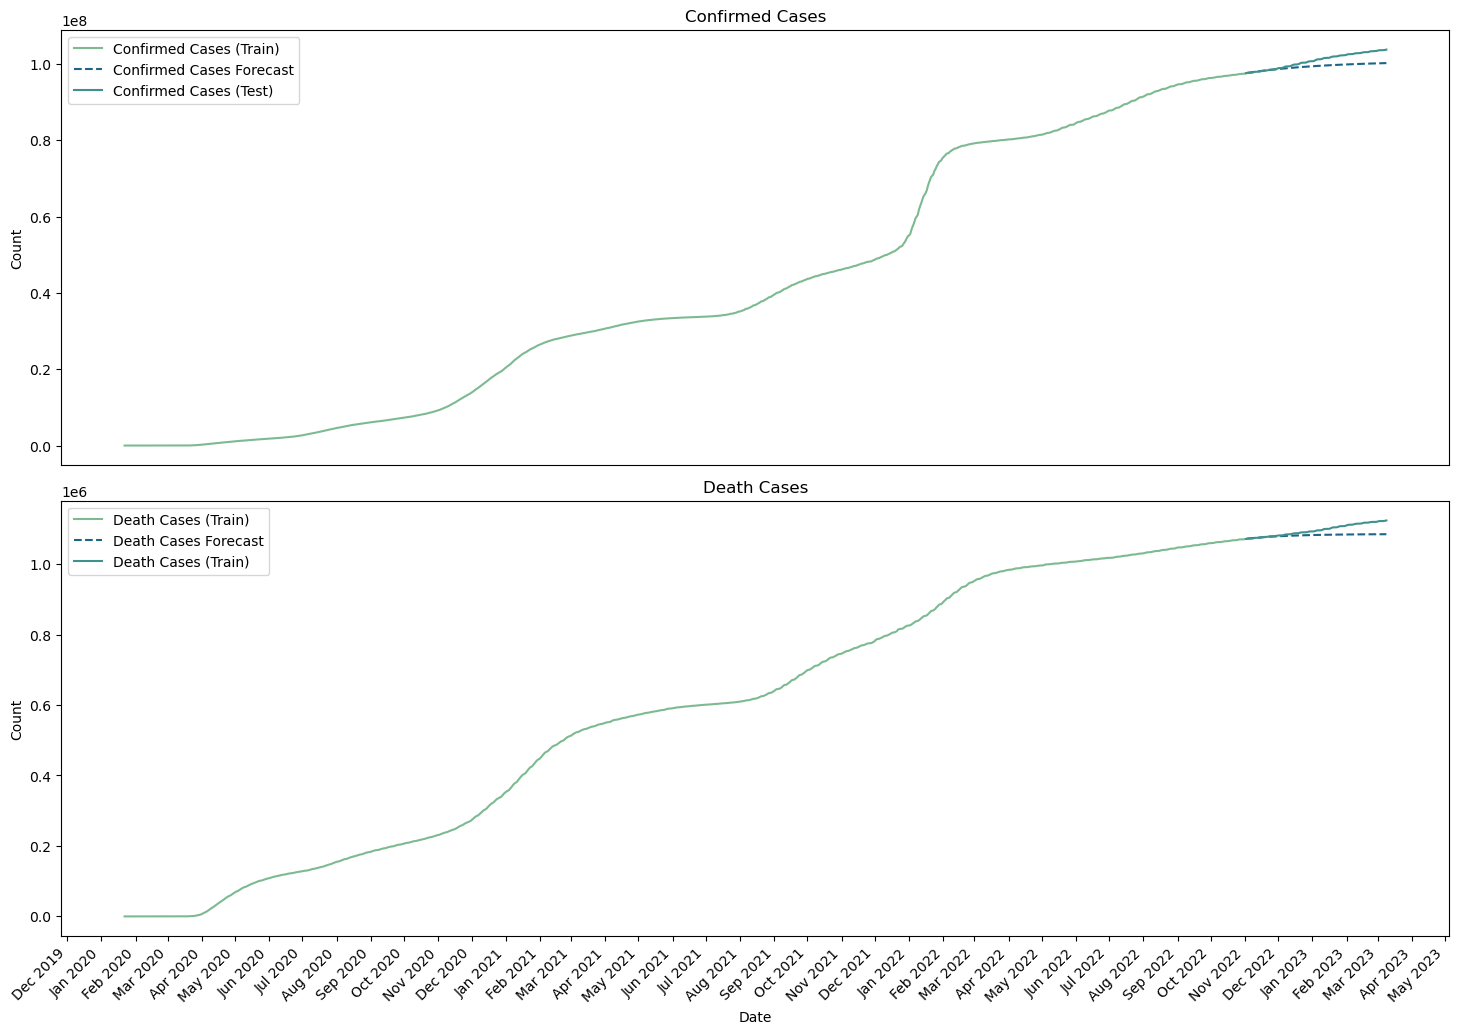

In [35]:

# Convert the datetime index to pandas datetime object
#df.index = pd.to_datetime(df.index)

# Localize the datetime index to UTC first
#df.index = df.index.tz_localize('UTC')

# Convert the datetime index to the specified timezone
df.index = df.index.tz_convert('America/New_York')

# Set the color palette
crest = sns.color_palette('crest')

# Log-transformed to original values
df['confirmed_original'] = np.exp(df['confirmed'])
df['death_original'] = np.exp(df['death'])
confirmed_pred_original = np.exp(confirmed_pred)
death_pred_original = np.exp(death_pred)

# Specify training end date and forecast periods
train_end_date = '2022-11-01'
forecast_start_date = '2022-11-02'
forecast_periods = len(df['confirmed'][forecast_start_date:])

# Plotting Confirmed Cases
plt.figure(figsize=(15, 10))
plt.subplot(2, 1, 1)  # 1 row, 2 columns, first plot
plt.plot(df['confirmed_original'][:train_end_date], label='Confirmed Cases (Train)', color=crest[0])
plt.plot(df['confirmed'][forecast_start_date:].index, confirmed_pred_original[-forecast_periods:], label='Confirmed Cases Forecast', linestyle='--', color=crest[4])
plt.plot(df['confirmed_original'][train_end_date:], label='Confirmed Cases (Test)', color=crest[2])
plt.title('Confirmed Cases')
plt.ylabel('Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.legend()
plt.xticks([])

# Plotting Death Cases
plt.subplot(2, 1, 2)  # 1 row, 2 columns, second plot
plt.plot(df['death_original'][:train_end_date], label='Death Cases (Train)', color=crest[0])
plt.plot(df['death'][forecast_start_date:].index, death_pred_original[-forecast_periods:], label='Death Cases Forecast', linestyle='--', color=crest[4])
plt.plot(df['death_original'][train_end_date:], label='Death Cases (Train)', color=crest[2])
plt.title('Death Cases')
plt.xlabel('Date')
plt.ylabel('Count')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.legend()

# Save both plots to files
plt.savefig('../Images/plot_forecasting.png')

plt.tight_layout()  # Adjust layout for better spacing
plt.xticks(rotation=45, ha='right')
plt.show()


## Saved models and forecastings

In [37]:
# Save models and predictions
model_data = {
    'confirmed_model': confirmed_model,
    'death_model': death_model,
    'confirmed_results': confirmed_results,
    'death_results': death_results,
    'confirmed_pred': confirmed_pred,
    'death_pred': death_pred
}

folder_path = '../Models'

with open(os.path.join(folder_path, 'confirmed_model.pkl'), 'wb') as file:
    pickle.dump(confirmed_model, file)

with open(os.path.join(folder_path, 'death_model.pkl'), 'wb') as file:
    pickle.dump(death_model, file)

with open(os.path.join(folder_path, 'confirmed_results.pkl'), 'wb') as file:
    pickle.dump(confirmed_results, file)

with open(os.path.join(folder_path, 'death_results.pkl'), 'wb') as file:
    pickle.dump(death_results, file)

with open(os.path.join(folder_path, 'confirmed_pred.pkl'), 'wb') as file:
    pickle.dump(confirmed_pred, file)

with open(os.path.join(folder_path, 'death_pred.pkl'), 'wb') as file:
    pickle.dump(death_pred, file)



print(f'Models and predictions saved successfully in the "{folder_path}" folder.')

Models and predictions saved successfully in the "../Models" folder.
